<a href="https://colab.research.google.com/github/le-pigeon/fantastic-winner/blob/main/Testing_deep_unrolled_algo__supervised_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Colab test

In [1]:
import glob
import cv2
import numpy as np
import torch
import torch.nn as nn  # ✅ Add this!
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import os
import random

In [2]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [3]:
# ✅ Step 1: Mount Google Drive
from google.colab import drive
import zipfile
import os

# drive.mount('/content/drive')  # Connect to your Google Drive

# ✅ Step 2: Define Paths
#zip_path = "/content/drive/MyDrive/SAR_Project/Dataset/UCMerced_LandUse.zip"  # Adjust path if needed
# extract_path = "/content/test_data/UCMerced_SAR_Dataset"  # Where to extract
zip_path = "/content/drive/MyDrive/SAR_Project/Dataset/SAR_paired.zip"
extract_path = "/content/test_data/SAR_Dataset"  # Where to extract


# ✅ Step 3: Extract ZIP
print("🔥 Extracting dataset... this may take a moment!")
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("✅ Extraction complete!")

# ✅ Step 4: Verify Files
print("📂 Checking extracted files...")
print(os.listdir(extract_path)[:10])  # Show first 10 files/folders

🔥 Extracting dataset... this may take a moment!
✅ Extraction complete!
📂 Checking extracted files...
['SAR despeckling filters dataset']


In [4]:
# Colab-ready PyTorch Implementation of SAR-DURNet (Deep Unrolling for SAR Despeckling)
# This script trains a deep unrolling network for SAR despeckling.
# Steps:
# 0. Pay for premium GPU :)
# 1. Set up dataset (simulated speckle noise on optical images)
# 2. Define SAR-DURNet model
# 3. Train with Charbonnier + Total Variation loss
# 4. Test on real SAR images



# Automatically select CPU if no GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🔥 Using device: {device}")

🔥 Using device: cuda


In [5]:
###############################################################################
############################## PAIRED DATASET #################################
###############################################################################

# Load to CPU RAM first
noisy_images = []
clean_images = []

# Path to your folders
noisy_folder = "/content/test_data/SAR_Dataset/SAR despeckling filters dataset/Main folder/Noisy"
clean_folder = "/content/test_data/SAR_Dataset/SAR despeckling filters dataset/Main folder/GTruth"

# Load all image paths
noisy_paths = sorted(glob.glob(os.path.join(noisy_folder, "*.tiff")))
clean_paths = sorted(glob.glob(os.path.join(clean_folder, "*.tiff")))

# Load the images to CPU RAM
for noisy_path, clean_path in zip(noisy_paths, clean_paths):
    noisy = cv2.imread(noisy_path, cv2.IMREAD_GRAYSCALE) / 255.0
    clean = cv2.imread(clean_path, cv2.IMREAD_GRAYSCALE) / 255.0

    # Store as torch tensors (but stay in CPU RAM)
    noisy_images.append(torch.tensor(noisy).unsqueeze(0))  # (1, H, W)
    clean_images.append(torch.tensor(clean).unsqueeze(0))  # (1, H, W)

print(f"🔥 Loaded {len(noisy_images)} noisy-clean SAR image pairs to CPU RAM!")


class PairedSARDataset(Dataset):
    def __init__(self, noisy_images, clean_images):
        self.noisy_images = noisy_images
        self.clean_images = clean_images

    def __getitem__(self, index):
        noisy = self.noisy_images[index]
        clean = self.clean_images[index]

        # ✅ Move to GPU only when accessed
        return noisy.float(), clean.float()


    def __len__(self):
        return len(self.noisy_images)



🔥 Loaded 1500 noisy-clean SAR image pairs to CPU RAM!


In [6]:
# Create Paired Dataset
train_dataset = PairedSARDataset(noisy_images, clean_images)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, pin_memory=True)


print(f"✅ Ready to train on {len(train_dataset)} images!")


✅ Ready to train on 1500 images!


In [ ]:
###############################################################################
############################## SIMULATED DATASET ##############################
###############################################################################

# Choose this or Paired


class UCSARImageDataset(Dataset):

    def __init__(self, root_dir, transform=None, L_start=1, L_end=5, epochs=20, img_size=(256, 256)):
        """Loads all images from multiple subfolders, converts to grayscale, and resizes them."""
        self.image_paths = sorted(glob.glob(os.path.join(root_dir, "**/*.tif"), recursive=True))
        if len(self.image_paths) == 0:
            self.image_paths = sorted(glob.glob(os.path.join(root_dir, "**/*.png"), recursive=True))
        if len(self.image_paths) == 0:
            self.image_paths = sorted(glob.glob(os.path.join(root_dir, "**/*.jpg"), recursive=True))
        if len(self.image_paths) == 0:
            self.image_paths = sorted(glob.glob(os.path.join(root_dir, "**/*.bmp"), recursive=True))  # 🔥 Added BMP support!
        self.transform = transform
        self.L_start = L_start
        self.L_end = L_end
        self.epochs = epochs
        self.img_size = img_size
        self.current_epoch = 0  # To track noise reduction

    def add_speckle_noise(self, image):
        """Progressively reduce speckle noise as training goes on."""
        L_dynamic = np.interp(self.current_epoch, [0, self.epochs], [self.L_start, self.L_end])
        noise = np.random.gamma(L_dynamic, 1.0 / L_dynamic, image.shape)
        return np.clip(image * noise, 0, 1)


    def add_frequency_based_speckle(self, image, min_L=1, max_L=5, cutoff=0.2):
        """Adds SAR speckle noise with controlled size using frequency filtering."""
        L = np.random.randint(min_L, max_L + 1)
        noise = np.random.gamma(L, 1.0 / L, image.shape)  # ✅ Fixed divide by zero bug by adding epsilon!

        # Convert to frequency domain
        noise_fft = np.fft.fft2(noise)
        h, w = noise.shape
        mask = np.zeros((h, w), np.float32)
        mask[int(h*cutoff):int(h*(1-cutoff)), int(w*cutoff):int(w*(1-cutoff))] = 1  # 🔥 Keep low frequencies

        # Apply frequency mask to control speckle size
        noise_filtered = np.fft.ifft2(noise_fft * mask).real
        speckled = image * noise_filtered

        return np.clip(speckled, 0, 1)


    def add_randomized_speckle_noise(self, image):
        """🔥 Add smarter SAR speckle noise."""
        brightness = np.mean(image)
        if brightness < 0.3:  # Very dark image
            L = np.random.randint(3, 8)  # More looks (less noise)
        elif brightness > 0.7:  # Very bright image
            L = np.random.randint(1, 3)  # Aggressive noise
        else:
            L = np.random.randint(self.L_start, self.L_end)

        noise = np.random.gamma(L, 1.0 / L, image.shape)
        return np.clip(image * noise, 0, 1)


    def add_scaled_speckle_noise(self, image, min_L=1, max_L=5, kernel_size=5):
      """Adds SAR-like speckle noise with variable size using Gaussian blur."""
      L = np.random.randint(min_L, max_L + 1)  # 🔥 Random number of looks
      noise = np.random.gamma(L, 1.0 / L, image.shape)

      if kernel_size > 1:  # 🔥 Adjust noise grain size
          noise = cv2.GaussianBlur(noise, (kernel_size, kernel_size), 0)

      speckled = image * noise
      return np.clip(speckled, 0, 1)

    def normalize_image(self, img):
        """🔥 Normalize SAR image to [0, 1] with adjusted contrast."""
        img_min = np.percentile(img, 1)  # Ignore extreme black pixels
        img_max = np.percentile(img, 99)  # Ignore very bright pixels
        img = np.clip((img - img_min) / (img_max - img_min + 1e-8), 0, 1)
        return img



    def __getitem__(self, index):
        img = cv2.imread(self.image_paths[index], cv2.IMREAD_GRAYSCALE).astype(np.float32)
        img = cv2.resize(img, self.img_size) / 255.0  # ✅ Normalize after resizing

        # 🔥 New Secret Normalization Trick
        img = self.normalize_image(img)

        # 🔥 Add randomized speckle noise
        speckled = self.add_randomized_speckle_noise(img)

        if self.transform:
            img = self.transform(img)
            speckled = self.transform(speckled)

        return speckled.float(), img.float()

    def set_epoch(self, epoch):
        self.current_epoch = epoch

    def __len__(self):
        return len(self.image_paths)


# Define Transformations & Load Dataset
transform = transforms.Compose([transforms.ToTensor()])
# dataset_path = "/content/test_data/UCMerced_SAR_Dataset/UCMerced_LandUse/Images"
dataset_path = "/content/test_data/SAR_Dataset/SAR-despeckle-Dataset"
#train_dataset = UCSARImageDataset(dataset_path, transform=transform, img_size=(256, 256))
train_dataset = UCSARImageDataset(dataset_path, transform=transform, img_size=(128, 128))


train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)

print(f"Loaded {len(train_dataset)} images from dataset!")





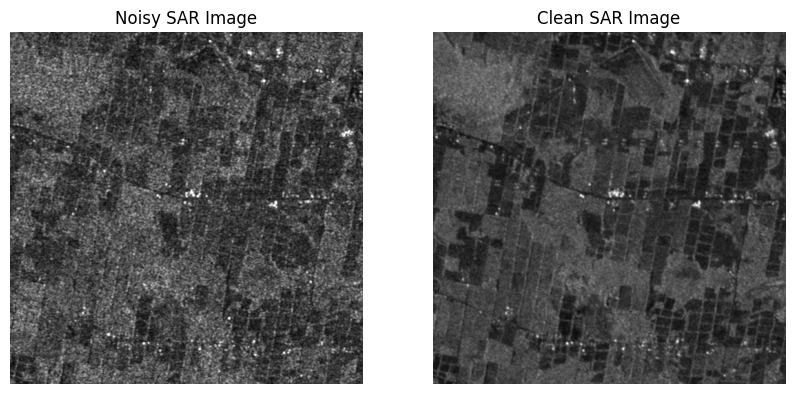

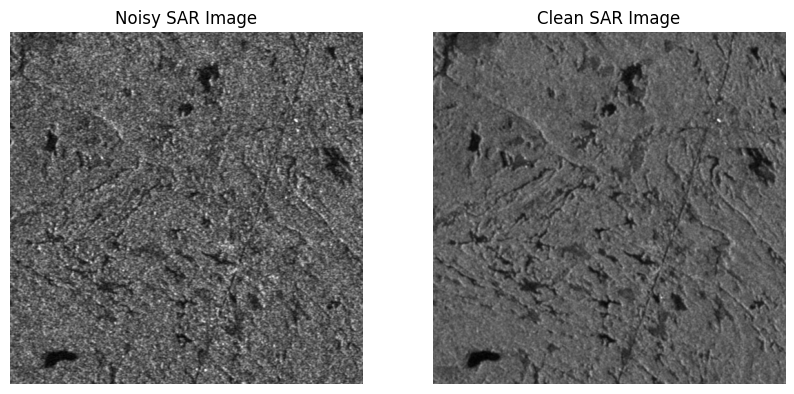

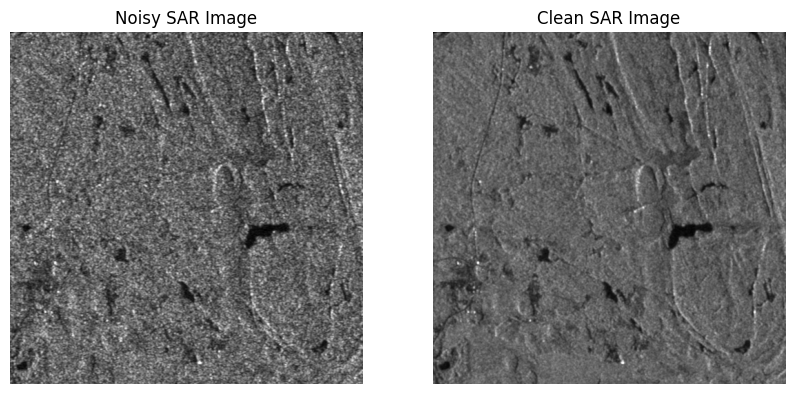

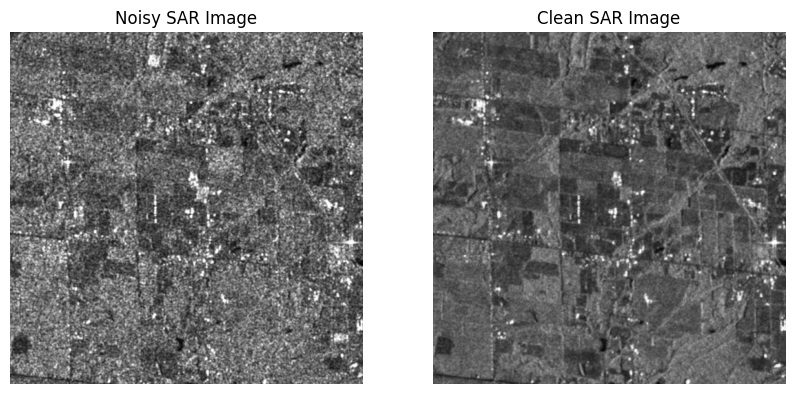

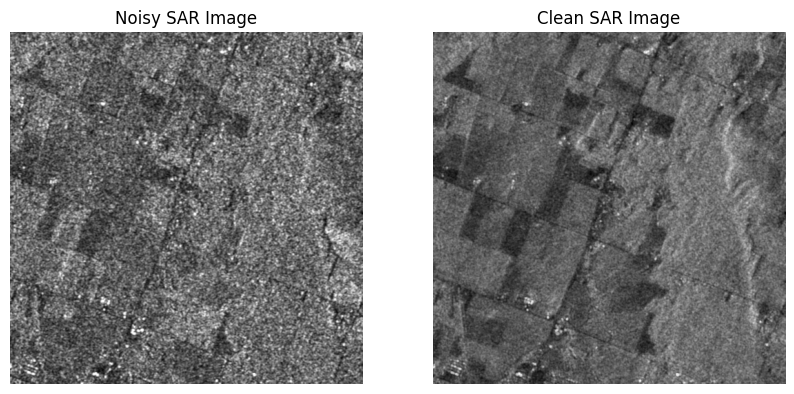

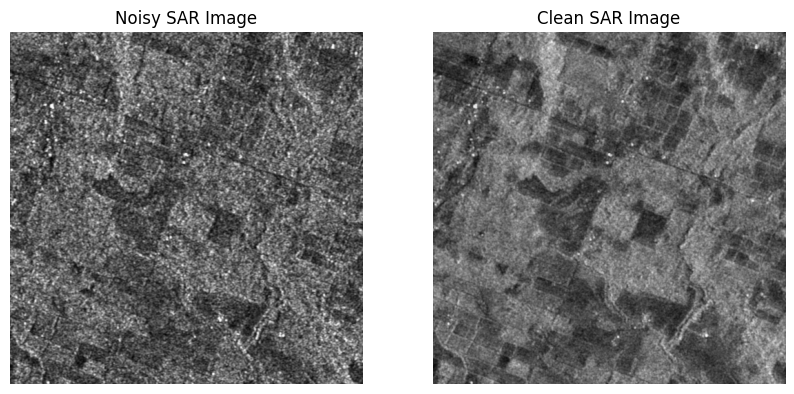

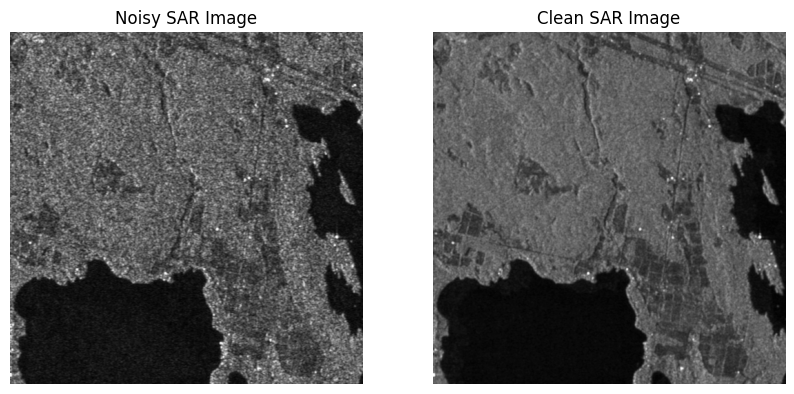

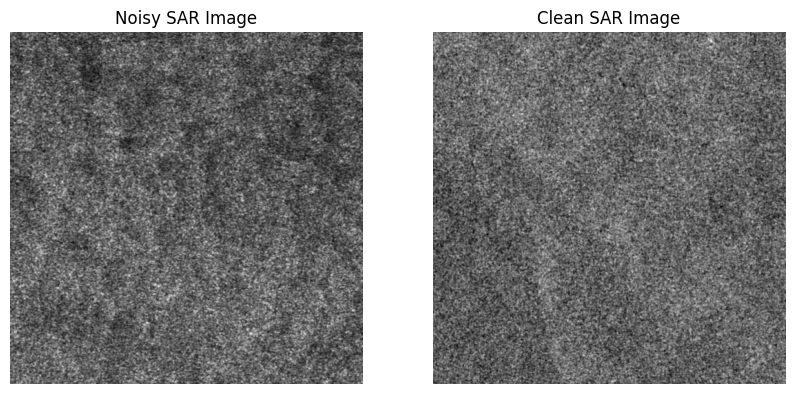

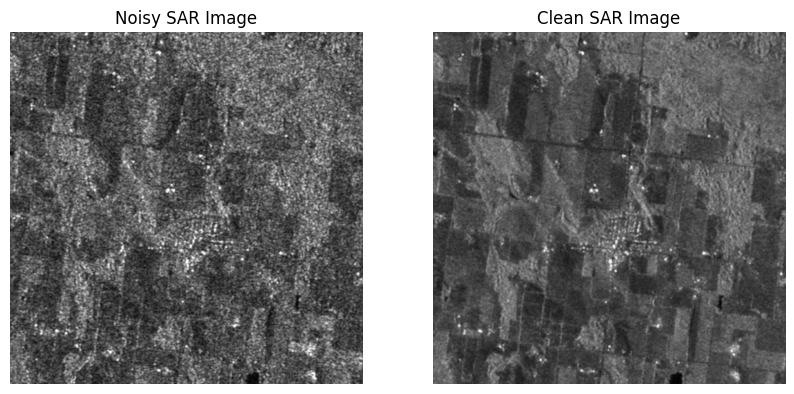

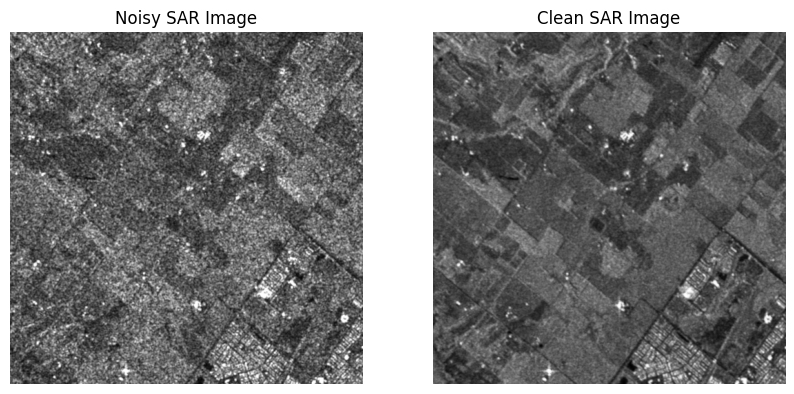

In [7]:
# Peek at training images OwO

import matplotlib.pyplot as plt
import random

# Function to show images
def show_random_images(noisy_images, clean_images, num_samples=10):
    """Display random noisy and clean SAR images."""
    indices = random.sample(range(len(noisy_images)), num_samples)

    for idx in indices:
        noisy = noisy_images[idx].squeeze().cpu().numpy()
        clean = clean_images[idx].squeeze().cpu().numpy()

        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(noisy, cmap='gray')
        plt.title("Noisy SAR Image")
        plt.axis("off")

        plt.subplot(1, 2, 2)
        plt.imshow(clean, cmap='gray')
        plt.title("Clean SAR Image")
        plt.axis("off")

        plt.show()

# ✅ Show 10 random images from the dataset
show_random_images(noisy_images, clean_images)

In [ ]:
for batch_idx, (noisy, clean) in enumerate(train_loader):
    if noisy.max() == 0 or clean.max() == 0:
        print(f"❌ WARNING: Pure black image found in Batch {batch_idx}")


In [8]:
class DenoisingAutoencoder(nn.Module):
    def __init__(self):
        super(DenoisingAutoencoder, self).__init__()

        # 🔥 Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),  # Downsampling
            nn.ReLU(),
            nn.Conv2d(64, 128, 3, stride=2, padding=1),  # Deeper features
            nn.ReLU()
        )

        # 🔥 Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1),  # Upsample
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),  # Upsample
            nn.ReLU(),
            nn.Conv2d(32, 1, 3, stride=1, padding=1),
            nn.Sigmoid()  # Normalize output between [0, 1]
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [9]:
# Residual U-Net (ResUNet) for SAR despeckling,
# Modified implementation from SAR2SAR

class ResUNet(nn.Module):
    def __init__(self, channels=1):
        super(ResUNet, self).__init__()

        # ✅ Encoder Path
        self.enc1 = self.conv_block(channels, 48)
        self.enc2 = self.conv_block(48, 48)
        self.enc3 = self.conv_block(48, 48)
        self.enc4 = self.conv_block(48, 48)
        self.enc5 = self.conv_block(48, 48)

        # ✅ Decoder Path
        self.dec5 = self.upconv_block(48, 48)
        self.dec4 = self.upconv_block(48, 48)
        self.dec3 = self.upconv_block(48, 48)
        self.dec2 = self.upconv_block(48, 48)
        self.dec1 = self.conv_block(48, 32)  # 🔥 Final conv, no upsample!

        # ✅ Channel Align 1x1 Convolutions
        self.align4 = nn.Conv2d(48, 48, kernel_size=1)
        self.align3 = nn.Conv2d(48, 48, kernel_size=1)
        self.align2 = nn.Conv2d(48, 48, kernel_size=1)
        self.align1 = nn.Conv2d(48, 48, kernel_size=1)

        # ✅ Final Output Layer
        self.final_conv = nn.Conv2d(32, 1, kernel_size=3, padding=1)

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.LeakyReLU(0.1),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.LeakyReLU(0.1)
        )

    def upconv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),  # ✅ Fixed upsample method
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.LeakyReLU(0.1)
        )

    def crop(self, enc_feat, dec_feat):
        """Handles size mismatch due to padding issues."""
        _, _, h, w = dec_feat.size()
        enc_feat = F.interpolate(enc_feat, size=(h, w), mode='bilinear', align_corners=False)
        return enc_feat

    def forward(self, x):
        # ✅ Encoder Path
        e1 = self.enc1(x)
        e2 = self.enc2(F.max_pool2d(e1, 2))
        e3 = self.enc3(F.max_pool2d(e2, 2))
        e4 = self.enc4(F.max_pool2d(e3, 2))
        e5 = self.enc5(F.max_pool2d(e4, 2))

        # ✅ Decoder Path (with Fixed Skip Connection)
        d5 = self.dec5(e5) + self.crop(e4, self.dec5(e5))
        d4 = self.dec4(d5) + self.crop(e3, self.dec4(d5))
        d3 = self.dec3(d4) + self.crop(e2, self.dec3(d4))
        d2 = self.dec2(d3) + self.crop(e1, self.dec2(d3))
        d1 = self.dec1(d2)

        # ✅ Final Output
        return x - self.final_conv(d1)


In [10]:
test_input = torch.randn(1, 1, 256, 256)  # Simulated SAR patch
model = ResUNet()
output = model(test_input)

print("🔥 ResUNet Output Shape:", output.shape)  # ✅ Should match (1, 1, 256, 256)


🔥 ResUNet Output Shape: torch.Size([1, 1, 256, 256])


In [11]:
# ========== 2. SAR-DURNet: Deep Unrolling Model ==========
class SAR_DURNet(nn.Module):
    def __init__(self, num_layers=6):
        super(SAR_DURNet, self).__init__()
        self.num_layers = num_layers
        self.resunet = ResUNet()

        # ✅ Unrolling steps
        self.gradient_steps = nn.ModuleList([
            nn.Conv2d(1, 1, kernel_size=3, padding=1) for _ in range(num_layers)
        ])

    def forward(self, x):
        v = x  # Initial guess
        for i in range(self.num_layers):
            noise_est = self.resunet(v)
            x = x - 0.1 * self.gradient_steps[i](noise_est)
            v = torch.relu(x)

        return x - self.resunet(v)

model = SAR_DURNet().to(device)  # Move model to CPU or GPU

# ========== 3. Loss Function & Optimizer ==========
def charbonnier_loss(x, y, epsilon=1e-6):  # 🔥 Increase epsilon to prevent division issues
    diff = x - y
    return torch.mean(torch.sqrt(diff ** 2 + epsilon))

def soft_clamp(x, min_val=1e-6):
    return torch.where(x > min_val, x, min_val)

def total_variation_loss(img, epsilon=1e-6):
    diff1 = img[:, :, :-1] - img[:, :, 1:]  # Horizontal diff
    diff2 = img[:, :-1, :] - img[:, 1:, :]  # Vertical diff

    # ✅ Soft Clamp BEFORE sqrt to avoid NaN
    tv_loss = torch.mean(torch.sqrt(soft_clamp(diff1 ** 2) + epsilon)) + \
              torch.mean(torch.sqrt(soft_clamp(diff2 ** 2) + epsilon))

    return tv_loss

def high_freq_loss(output, clean, alpha=0.005):
    fft_output = torch.fft.fft2(output)
    fft_clean = torch.fft.fft2(clean)

    # ✅ Add epsilon to avoid NaN from empty frequency
    return alpha * torch.mean(torch.abs(fft_output - fft_clean) + 1e-6)


def edge_preserving_loss(output, clean, alpha=0.01):
    edges_output = torch.abs(output[:, :, :-1] - output[:, :, 1:])
    edges_clean = torch.abs(clean[:, :, :-1] - clean[:, :, 1:])

    # ✅ Use Soft Clamp Before Squaring
    return alpha * torch.mean(soft_clamp((edges_output - edges_clean) ** 2))

optimizer = optim.Adam(model.parameters(), lr=0.0001)



In [13]:
from tqdm import tqdm  # For sexy progress bar
import torch.cuda.memory as cuda_mem

num_epochs = 15  # Set the number of epochs (adjust as needed)

# ========== 4. Training Loop ==========
torch.set_default_tensor_type('torch.FloatTensor')  # ✅ Ensure everything is in float32


for epoch in range(num_epochs):
    torch.cuda.empty_cache()  # ✅ Free up unused GPU memory

    total_loss = 0.0
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"🔥 Epoch {epoch+1}/{num_epochs}")

    for batch_idx, (noisy, clean) in progress_bar:
        noisy, clean = noisy.float(), clean.float()
        noisy, clean = noisy.to(device, non_blocking=True), clean.to(device, non_blocking=True)

        optimizer.zero_grad()
        output = model(noisy)

        loss = charbonnier_loss(output, clean) + edge_preserving_loss(output, clean)
        loss.backward()
        optimizer.step()

        # ✅ Accumulate loss
        total_loss += loss.item()

        # ✅ Track CUDA memory usage (corrected this babe 😎)
        gpu_mem = torch.cuda.memory_allocated(device) / 1024**3

        # ✅ Update progress bar with loss & GPU usage
        progress_bar.set_postfix(loss=f"{loss.item():.4f}", gpu=f"{gpu_mem:.2f} GB")

        # ✅ Show 1 despeckled image every 10 batches
        if batch_idx % 10 == 0:
            sample_noisy = noisy[0].squeeze().detach().cpu().numpy()
            sample_clean = clean[0].squeeze().detach().cpu().numpy()
            sample_denoised = output[0].squeeze().detach().cpu().numpy()
            # show_images(sample_noisy, sample_denoised, sample_clean)

    # ✅ Show average loss at the end of each epoch
    print(f"✅ Epoch {epoch+1} | Avg Loss: {total_loss / len(train_loader):.6f}\n")


# ========== 5. Save Model ==========
os.makedirs("/content/model", exist_ok=True)  # ✅ Create folder if it doesn't exist
torch.save(model.state_dict(), "/content/model/sar_durnet.pth")
print("Model saved!")

🔥 Epoch 1/15: 100%|██████████| 188/188 [01:53<00:00,  1.65it/s, gpu=0.02 GB, loss=0.0483]


✅ Epoch 1 | Avg Loss: 0.061318



🔥 Epoch 2/15: 100%|██████████| 188/188 [01:53<00:00,  1.65it/s, gpu=0.02 GB, loss=0.0400]


✅ Epoch 2 | Avg Loss: 0.040167



🔥 Epoch 3/15: 100%|██████████| 188/188 [01:53<00:00,  1.65it/s, gpu=0.02 GB, loss=0.0384]


✅ Epoch 3 | Avg Loss: 0.038742



🔥 Epoch 4/15: 100%|██████████| 188/188 [01:53<00:00,  1.65it/s, gpu=0.02 GB, loss=0.0390]


✅ Epoch 4 | Avg Loss: 0.038157



🔥 Epoch 5/15: 100%|██████████| 188/188 [01:53<00:00,  1.65it/s, gpu=0.02 GB, loss=0.0345]


✅ Epoch 5 | Avg Loss: 0.037179



🔥 Epoch 6/15: 100%|██████████| 188/188 [01:53<00:00,  1.65it/s, gpu=0.02 GB, loss=0.0286]


✅ Epoch 6 | Avg Loss: 0.036653



🔥 Epoch 7/15: 100%|██████████| 188/188 [01:53<00:00,  1.65it/s, gpu=0.02 GB, loss=0.0344]


✅ Epoch 7 | Avg Loss: 0.036065



🔥 Epoch 8/15: 100%|██████████| 188/188 [01:53<00:00,  1.65it/s, gpu=0.02 GB, loss=0.0448]


✅ Epoch 8 | Avg Loss: 0.035805



🔥 Epoch 9/15: 100%|██████████| 188/188 [01:53<00:00,  1.65it/s, gpu=0.02 GB, loss=0.0407]


✅ Epoch 9 | Avg Loss: 0.035528



🔥 Epoch 10/15: 100%|██████████| 188/188 [01:53<00:00,  1.65it/s, gpu=0.02 GB, loss=0.0386]


✅ Epoch 10 | Avg Loss: 0.035238



🔥 Epoch 11/15: 100%|██████████| 188/188 [01:53<00:00,  1.65it/s, gpu=0.02 GB, loss=0.0330]


✅ Epoch 11 | Avg Loss: 0.035014



🔥 Epoch 12/15: 100%|██████████| 188/188 [01:53<00:00,  1.65it/s, gpu=0.02 GB, loss=0.0378]


✅ Epoch 12 | Avg Loss: 0.034805



🔥 Epoch 13/15: 100%|██████████| 188/188 [01:53<00:00,  1.65it/s, gpu=0.02 GB, loss=0.0305]


✅ Epoch 13 | Avg Loss: 0.034621



🔥 Epoch 14/15: 100%|██████████| 188/188 [01:53<00:00,  1.65it/s, gpu=0.02 GB, loss=0.0291]


✅ Epoch 14 | Avg Loss: 0.034510



🔥 Epoch 15/15: 100%|██████████| 188/188 [01:53<00:00,  1.65it/s, gpu=0.02 GB, loss=0.0244]

✅ Epoch 15 | Avg Loss: 0.034033

Model saved!


In [23]:
import torch
torch.cuda.empty_cache()
torch.cuda.empty_cache()

Took about 22min for 20 epochs last time

* Testing for 15 epochs is enough?






In [14]:
# 🔥 Folder path
folder_name = "/content/imported_images"

# 🔥 Create if doesn't exist
os.makedirs(folder_name, exist_ok=True)

🔥 Processing /content/imported_images/SG_Port.jpg...
✅ Saved despeckled image to /content/despeckled_results/despeckled_SG_Port.jpg


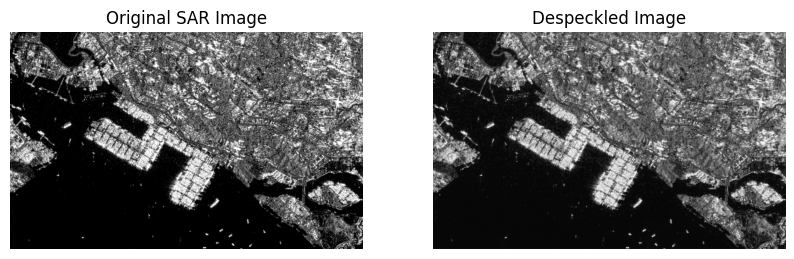

🔥 Processing /content/imported_images/SG_forest.tiff...
✅ Saved despeckled image to /content/despeckled_results/despeckled_SG_forest.tiff


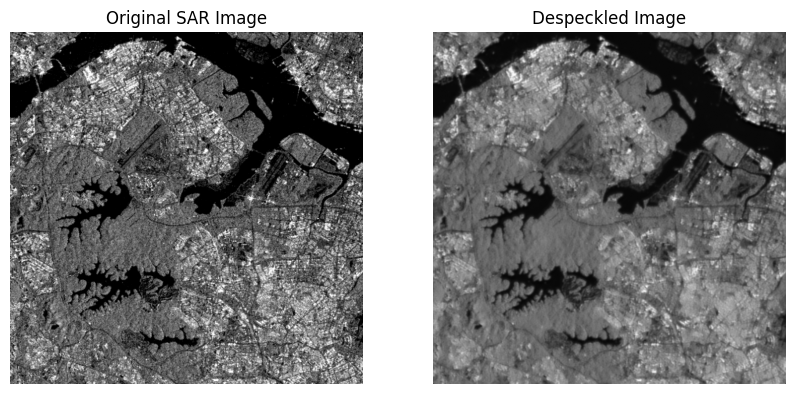

🔥 Processing /content/imported_images/adelaide_summer.jpg...
✅ Saved despeckled image to /content/despeckled_results/despeckled_adelaide_summer.jpg


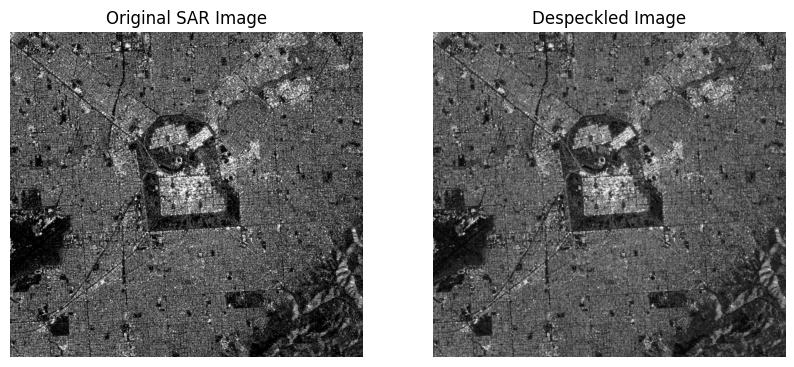

🔥 Processing /content/imported_images/bali_mt.tiff...
✅ Saved despeckled image to /content/despeckled_results/despeckled_bali_mt.tiff


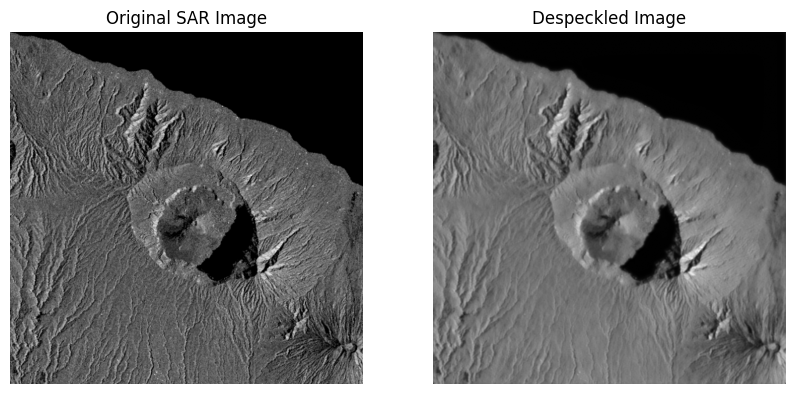

🔥 Processing /content/imported_images/chicago_summer.jpg...
✅ Saved despeckled image to /content/despeckled_results/despeckled_chicago_summer.jpg


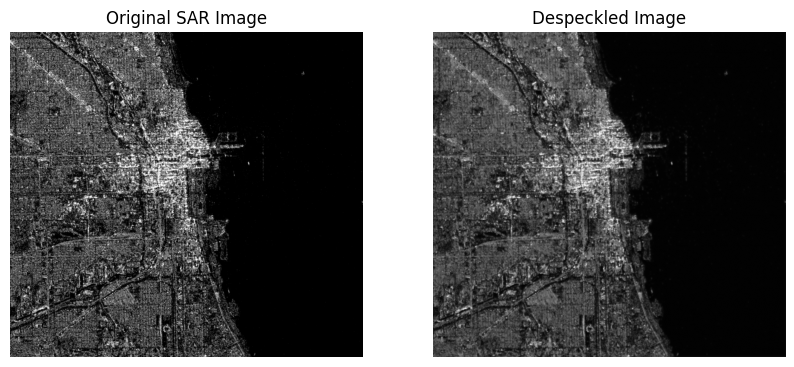

🔥 Processing /content/imported_images/hokkaido_summer.jpg...
✅ Saved despeckled image to /content/despeckled_results/despeckled_hokkaido_summer.jpg


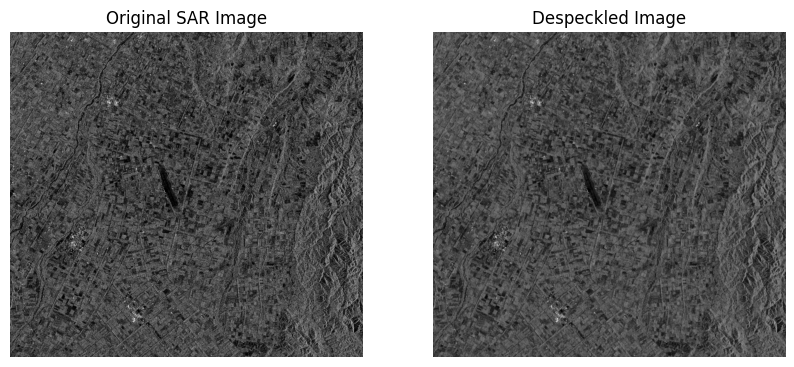

🔥 Processing /content/imported_images/hokkaido_winter.jpg...
✅ Saved despeckled image to /content/despeckled_results/despeckled_hokkaido_winter.jpg


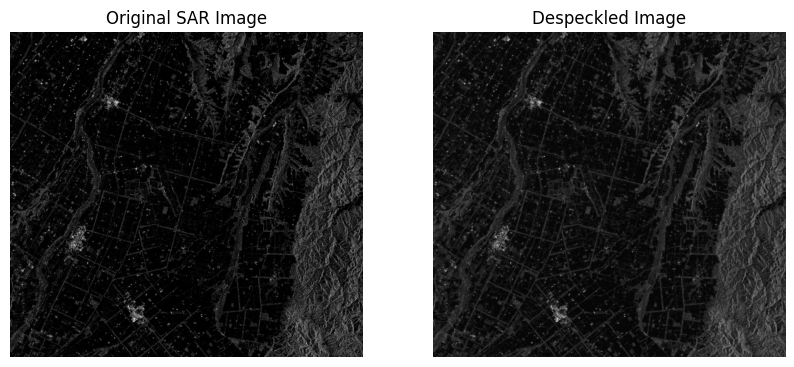

🔥 ALL IMAGES PROCESSED SUCCESSFULLY!


In [15]:
import glob
import cv2
import torch
import os
import matplotlib.pyplot as plt

# ✅ Define paths
input_folder = "/content/imported_images/"  # 🔥 Change this to your SAR image folder
output_folder = "/content/despeckled_results/"  # 🔥 Where despeckled images will be saved

# ✅ Make sure output folder exists
os.makedirs(output_folder, exist_ok=True)

# ✅ Load model in eval mode
model.eval()

# ✅ Find all SAR images in the folder
valid_extensions = ["tiff", "tif", "png", "jpg", "bmp"]
image_paths = sorted(
    [img for ext in valid_extensions for img in glob.glob(os.path.join(input_folder, f"*.{ext}"))]
)
  # 🔥 Change extension if needed

# ✅ Function to resize image to multiple of 32
def resize_to_multiple_of_32(image):
    """Resizes image to the nearest lower multiple of 32 for U-Net compatibility."""
    h, w = image.shape
    new_h = (h // 32) * 32  # Round down to nearest multiple of 32
    new_w = (w // 32) * 32
    return cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_AREA)

# ✅ Process each image
for img_path in image_paths:
    print(f"🔥 Processing {img_path}...")

    # Load image
    test_image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if test_image is None:
        print(f"❌ Skipping {img_path}, could not load image!")
        continue

    # Normalize & Resize
    test_image = test_image / 255.0  # Normalize to [0,1]
    test_image_resized = resize_to_multiple_of_32(test_image)

    # Convert to PyTorch tensor
    test_tensor = torch.tensor(test_image_resized, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)

    # ✅ Run through model
    with torch.no_grad():
        despeckled_image = model(test_tensor).squeeze().cpu().numpy()

    # 🔥 Save the despeckled image
    output_filename = "despeckled_" + os.path.basename(img_path)
    output_path = os.path.join(output_folder, output_filename)
    cv2.imwrite(output_path, (despeckled_image * 255).astype(np.uint8))  # Convert back to [0,255]

    print(f"✅ Saved despeckled image to {output_path}")

    # 🔥 Show Before & After
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(test_image_resized, cmap="gray")
    plt.title("Original SAR Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(despeckled_image, cmap="gray")
    plt.title("Despeckled Image")
    plt.axis("off")

    plt.show()  # ✅ Display the images

print("🔥 ALL IMAGES PROCESSED SUCCESSFULLY!")


In [17]:
# zip output folder to download ezpzggwp

import shutil
shutil.make_archive("/content/despeckled_results", 'zip', "/content/despeckled_results")

'/content/despeckled_results.zip'